In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import pathlib

In [2]:
gesture = ['palm', 'I', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down']

In [43]:
dataset_path = pathlib.Path('/content/drive/MyDrive/HandGestureDetection/dataset')

In [16]:
image_count = 0
for i in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, i)
    if os.path.isdir(class_path):
        num_images = len([
            f for f in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, f))])
        image_count += num_images

print(image_count)

20000


In [26]:
img_height = 100
img_width = 100
batch_size = 32

In [27]:
import random
import shutil

# Create directories for the reduced dataset
reduced_dataset_path = pathlib.Path('/content/reduced_dataset')
if reduced_dataset_path.exists():
    shutil.rmtree(reduced_dataset_path)
reduced_dataset_path.mkdir()

for gesture_name in gesture:
    (reduced_dataset_path / gesture_name).mkdir()

# Select 1/5 of the images for each class
fraction = 0.6 # 1/5

for gesture_name in gesture:
    class_path = dataset_path / gesture_name
    images = list(class_path.glob('*.png')) # Assuming images are png
    random.shuffle(images)
    num_to_select = int(len(images) * fraction)
    selected_images = images[:num_to_select]

    # Copy selected images to the new directory
    for img_path in selected_images:
        shutil.copy(img_path, reduced_dataset_path / gesture_name)

print(f"Created reduced dataset with approximately {fraction*100}% of the original images.")

Created reduced dataset with approximately 60.0% of the original images.


In [28]:
# Now use the reduced dataset for training and validation
train_dset = tf.keras.utils.image_dataset_from_directory(reduced_dataset_path,
                                                         validation_split=0.2,
                                                         subset="training",
                                                         seed=1296,
                                                         image_size=(img_height, img_width),
                                                         batch_size=batch_size)

val_dset = tf.keras.utils.image_dataset_from_directory(reduced_dataset_path,
                                                       validation_split=0.2,
                                                       subset="validation",
                                                       seed=1296,
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size)

Found 10800 files belonging to 10 classes.
Using 8640 files for training.
Found 10800 files belonging to 10 classes.
Using 2160 files for validation.


In [29]:
class_names1 = train_dset.class_names
print("classes:", class_names1)
class_names2 = val_dset.class_names
print("classes:", class_names2)

classes: ['I', 'c', 'down', 'fist', 'fist_moved', 'index', 'ok', 'palm', 'palm_moved', 'thumb']
classes: ['I', 'c', 'down', 'fist', 'fist_moved', 'index', 'ok', 'palm', 'palm_moved', 'thumb']


In [30]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([layers.Input(shape=(img_height, img_width, 3)),
                    layers.Rescaling(1./255),
                    layers.Conv2D(32, (3, 3), activation='relu'),  # tek gizli katman
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dropout(0.5),
                    layers.Dense(len(gesture), activation='softmax')  # Use number of classes and softmax for multi-class
                    ])

In [31]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 76832)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 76832)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │       768,330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769,226 (2.93 MB)

 Trainable params: 769,226 (2.93 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy', # Changed loss function for multi-class
              metrics=['accuracy'],

              )

In [33]:
epochs = 30

history = model.fit(train_dset,
                    validation_data=val_dset,
                    epochs=epochs
                    )

Epoch 1/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.4548 - loss: 1.6113 - val_accuracy: 0.8421 - val_loss: 0.6018
Epoch 2/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.8071 - loss: 0.6265 - val_accuracy: 0.9333 - val_loss: 0.3187
Epoch 3/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.8806 - loss: 0.4052 - val_accuracy: 0.9611 - val_loss: 0.2137
Epoch 4/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9053 - loss: 0.3325 - val_accuracy: 0.9657 - val_loss: 0.1816
Epoch 5/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9276 - loss: 0.2646 - val_accuracy: 0.9736 - val_loss: 0.1455
Epoch 6/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9395 - loss: 0.2270 - val_accuracy: 0.9745 - val_loss: 0.1185
Epoch 7/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9488 - loss: 0.1958 - val_accuracy: 0.9588 - val_loss: 0.1699
Epoch 8/30
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - accuracy: 0.9498 - loss: 0.1794 - 

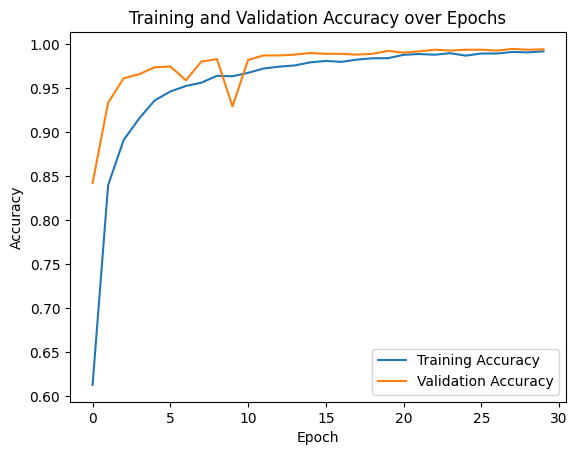

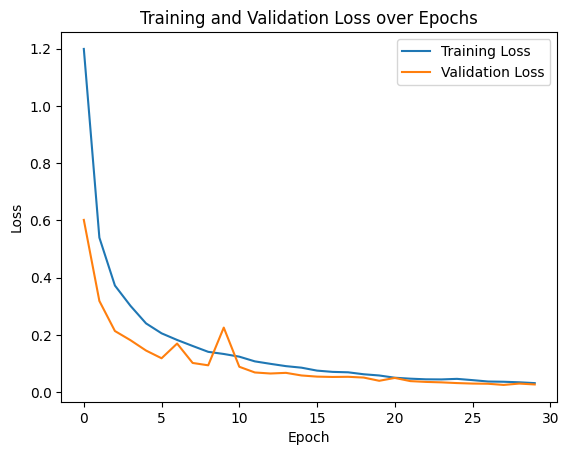

In [34]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


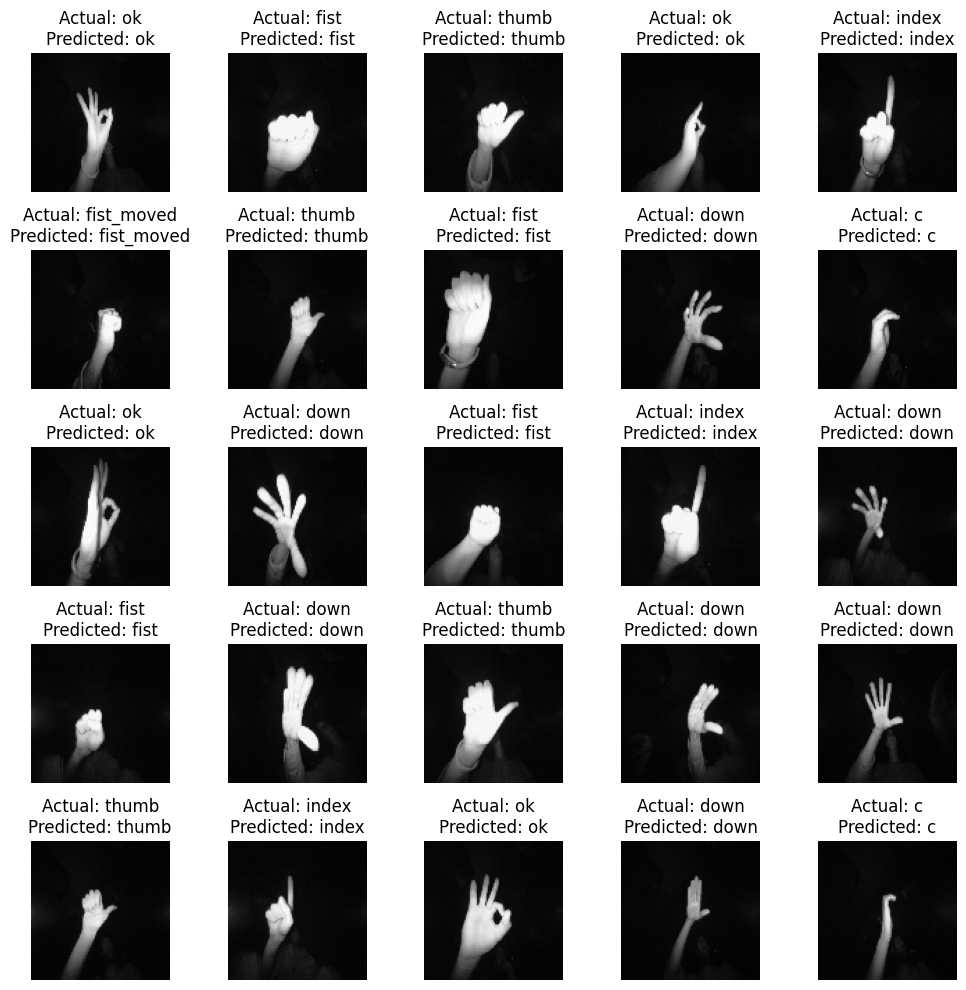

In [40]:
import random
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Get a list of all image paths in the reduced dataset
all_image_paths = list(reduced_dataset_path.glob('*/*.png')) # Assuming images are png

# Select a few random images
num_random_images = 25
random_image_paths = random.sample(all_image_paths, num_random_images)

plt.figure(figsize=(10, 10))
rows = 5
cols = 5

for i, img_path in enumerate(random_image_paths):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names1[predicted_class_index]

    # Get the actual class name
    actual_class_name = img_path.parent.name

    # Display the image and prediction
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Actual: {actual_class_name}\nPredicted: {predicted_class_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [42]:
model.save('/content/drive/MyDrive/HandGestureDetection/hand_sign_model.h5')